In [3]:

import numpy as np
from pymatgen.phonon.plotter import PhononBSPlotter
from mp_api.client import MPRester
import matplotlib.pyplot as plt
from scipy.stats import linregress


In [ ]:
mp_key = "fShF0m8lEepeLAjHYRHR50cMgpJGq7yr"
mp_id = "mp-16763"
with MPRester(mp_key) as m:
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)
    

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

### Structure de bandes des phonons

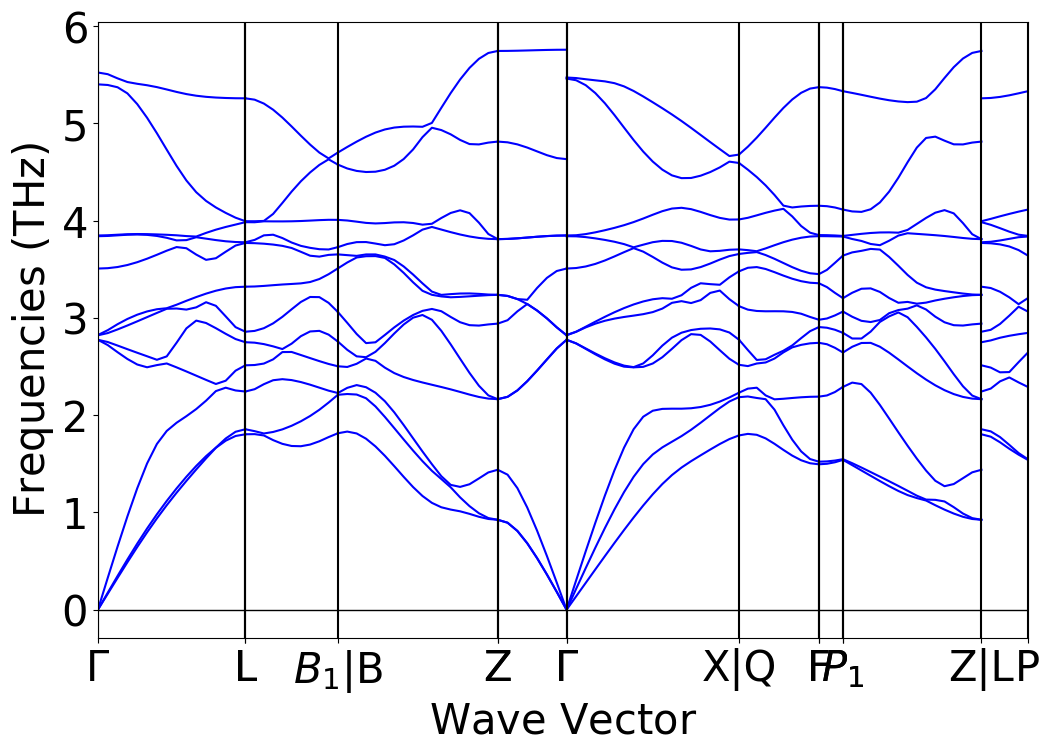

In [8]:
plotter = PhononBSPlotter(ph_bs)
bs = plotter.bs_plot_data()
plotter.show()

### Zone de Brillouin 

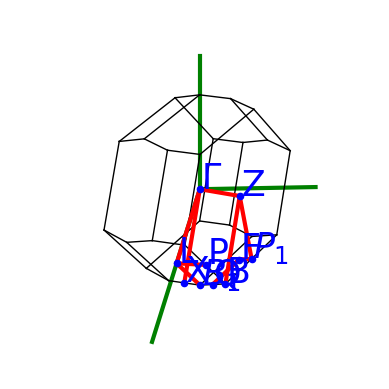

In [9]:
plotter.plot_brillouin()

### Calcul de la vitesse du son dans les 3 branches acoustiques différentes dans 3 directions différentes de la zone de Brillouin

Pour chaque direction :
   - On extrait les **fréquences des 3 premières branches acoustiques** (généralement les 3 plus basses).
   - On prend les **4 premiers points** près de $\Gamma$.
   - On effectue une **régression linéaire** (approximation locale de la pente).
   - La pente $\frac{df}{dk}$ est convertie en **vitesse du son** avec la formule : $v$ = 2 $\pi$ $\cdot$ $\left| \frac{df}{dk} \right|$ 
    
     où :
     - $f$ est la fréquence (en THz),
     - $k$ est le vecteur d’onde (en Å⁻¹),
     - $v$ est la vitesse en m/s.
 


In [20]:
gamma_directions = []
for i, (start, end) in enumerate(zip(bs["ticks"]["label"][:-1], bs["ticks"]["label"][1:])):
    if start == "$\Gamma$" or end == "$\Gamma$":
        gamma_directions.append((i, f"{start or '?'} → {end or '?'}"))

# Afficher les directions valides (autour de Γ)
for i, (idx, label) in enumerate(gamma_directions):
    print(f"{i}: {label}")



0: $\Gamma$ → L
1: Z → $\Gamma$
2: $\Gamma$ → $\Gamma$
3: $\Gamma$ → X|Q


In [37]:
def calculate_speed_of_sound(distances, frequencies, label):
    d = np.array(distances[:4])
    f = np.array(frequencies[:4])
    slope, _, _, _, _ = linregress(d, f)
    velocity = 2 * np.pi * np.abs(slope) * 100  # Conversion THz/Å⁻¹ → m/s
    print(f"{label} : pente ≈ {slope:.4f} THz/Å⁻¹ → vitesse ≈ {velocity:.2f} m/s")
    return velocity


In [41]:
# Modifier cette liste après avoir vu l'affichage précédent
selected_gamma_indices = [0, 1, 3]  # Indices dans gamma_directions

velocities = {}

for sel in selected_gamma_indices:
    idx, label = gamma_directions[sel]
    distances = bs["distances"][idx]
    frequencies = bs["frequency"][idx]

    print(f"\n--- {label} ---")
    for i in range(3):  # Branches acoustiques
        v = calculate_speed_of_sound(distances, [f[i] for f in frequencies], f"{label}, branche {i+1}")
        velocities[(label, i+1)] = v




--- $\Gamma$ → L ---
$\Gamma$ → L, branche 1 : pente ≈ 15.0324 THz/Å⁻¹ → vitesse ≈ 9445.14 m/s
$\Gamma$ → L, branche 2 : pente ≈ 14.1253 THz/Å⁻¹ → vitesse ≈ 8875.19 m/s
$\Gamma$ → L, branche 3 : pente ≈ 13.1146 THz/Å⁻¹ → vitesse ≈ 8240.15 m/s

--- Z → $\Gamma$ ---
Z → $\Gamma$, branche 1 : pente ≈ 4.4463 THz/Å⁻¹ → vitesse ≈ 2793.66 m/s
Z → $\Gamma$, branche 2 : pente ≈ 4.3400 THz/Å⁻¹ → vitesse ≈ 2726.87 m/s
Z → $\Gamma$, branche 3 : pente ≈ 4.6061 THz/Å⁻¹ → vitesse ≈ 2894.09 m/s

--- $\Gamma$ → X|Q ---
$\Gamma$ → X|Q, branche 1 : pente ≈ 7.7997 THz/Å⁻¹ → vitesse ≈ 4900.72 m/s
$\Gamma$ → X|Q, branche 2 : pente ≈ 8.6147 THz/Å⁻¹ → vitesse ≈ 5412.79 m/s
$\Gamma$ → X|Q, branche 3 : pente ≈ 9.2125 THz/Å⁻¹ → vitesse ≈ 5788.39 m/s
